# Starbucks Capstone Challenge

### Introduction

This data set contains simulated data that mimics customer behavior on the Starbucks rewards mobile app. Once every few days, Starbucks sends out an offer to users of the mobile app. An offer can be merely an advertisement for a drink or an actual offer such as a discount or BOGO (buy one get one free). Some users might not receive any offer during certain weeks. 

Not all users receive the same offer, and that is the challenge to solve with this data set.

Your task is to combine transaction, demographic and offer data to determine which demographic groups respond best to which offer type. This data set is a simplified version of the real Starbucks app because the underlying simulator only has one product whereas Starbucks actually sells dozens of products.

Every offer has a validity period before the offer expires. As an example, a BOGO offer might be valid for only 5 days. You'll see in the data set that informational offers have a validity period even though these ads are merely providing information about a product; for example, if an informational offer has 7 days of validity, you can assume the customer is feeling the influence of the offer for 7 days after receiving the advertisement.

You'll be given transactional data showing user purchases made on the app including the timestamp of purchase and the amount of money spent on a purchase. This transactional data also has a record for each offer that a user receives as well as a record for when a user actually views the offer. There are also records for when a user completes an offer. 

Keep in mind as well that someone using the app might make a purchase through the app without having received an offer or seen an offer.

### Example

To give an example, a user could receive a discount offer buy 10 dollars get 2 off on Monday. The offer is valid for 10 days from receipt. If the customer accumulates at least 10 dollars in purchases during the validity period, the customer completes the offer.

However, there are a few things to watch out for in this data set. Customers do not opt into the offers that they receive; in other words, a user can receive an offer, never actually view the offer, and still complete the offer. For example, a user might receive the "buy 10 dollars get 2 dollars off offer", but the user never opens the offer during the 10 day validity period. The customer spends 15 dollars during those ten days. There will be an offer completion record in the data set; however, the customer was not influenced by the offer because the customer never viewed the offer.

### Cleaning

This makes data cleaning especially important and tricky.

You'll also want to take into account that some demographic groups will make purchases even if they don't receive an offer. From a business perspective, if a customer is going to make a 10 dollar purchase without an offer anyway, you wouldn't want to send a buy 10 dollars get 2 dollars off offer. You'll want to try to assess what a certain demographic group will buy when not receiving any offers.

### Final Advice

Because this is a capstone project, you are free to analyze the data any way you see fit. For example, you could build a machine learning model that predicts how much someone will spend based on demographics and offer type. Or you could build a model that predicts whether or not someone will respond to an offer. Or, you don't need to build a machine learning model at all. You could develop a set of heuristics that determine what offer you should send to each customer (i.e., 75 percent of women customers who were 35 years old responded to offer A vs 40 percent from the same demographic to offer B, so send offer A).

# Data Sets

The data is contained in three files:

* portfolio.json - containing offer ids and meta data about each offer (duration, type, etc.)
* profile.json - demographic data for each customer
* transcript.json - records for transactions, offers received, offers viewed, and offers completed

Here is the schema and explanation of each variable in the files:

**portfolio.json**
* id (string) - offer id
* offer_type (string) - type of offer ie BOGO, discount, informational
* difficulty (int) - minimum required spend to complete an offer
* reward (int) - reward given for completing an offer
* duration (int) - time for offer to be open, in days
* channels (list of strings)

**profile.json**
* age (int) - age of the customer 
* became_member_on (int) - date when customer created an app account
* gender (str) - gender of the customer (note some entries contain 'O' for other rather than M or F)
* id (str) - customer id
* income (float) - customer's income

**transcript.json**
* event (str) - record description (ie transaction, offer received, offer viewed, etc.)
* person (str) - customer id
* time (int) - time in hours since start of test. The data begins at time t=0
* value - (dict of strings) - either an offer id or transaction amount depending on the record

**Note:** If you are using the workspace, you will need to go to the terminal and run the command `conda update pandas` before reading in the files. This is because the version of pandas in the workspace cannot read in the transcript.json file correctly, but the newest version of pandas can. You can access the termnal from the orange icon in the top left of this notebook.  

You can see how to access the terminal and how the install works using the two images below.  First you need to access the terminal:

<img src="pic1.png"/>

Then you will want to run the above command:

<img src="pic2.png"/>

Finally, when you enter back into the notebook (use the jupyter icon again), you should be able to run the below cell without any errors.

In [542]:
import pandas as pd
import numpy as np
import math
import json
%matplotlib inline
import matplotlib.pyplot as plt

# read in the json files
portfolio = pd.read_json('data/portfolio.json', orient='records', lines=True)
profile = pd.read_json('data/profile.json', orient='records', lines=True)
transcript = pd.read_json('data/transcript.json', orient='records', lines=True)

In [543]:
transcript.head()

,person,event,value,time
0,78afa995795e4d85b5d9ceeca43f5fef,offer received,{'offer id': '9b98b8c7a33c4b65b9aebfe6a799e6d9'},0
1,a03223e636434f42ac4c3df47e8bac43,offer received,{'offer id': '0b1e1539f2cc45b7b9fa7c272da2e1d7'},0
2,e2127556f4f64592b11af22de27a7932,offer received,{'offer id': '2906b810c7d4411798c6938adc9daaa5'},0
3,8ec6ce2a7e7949b1bf142def7d0e0586,offer received,{'offer id': 'fafdcd668e3743c1bb461111dcafc2a4'},0
4,68617ca6246f4fbc85e91a2a49552598,offer received,{'offer id': '4d5c57ea9a6940dd891ad53e9dbe8da0'},0


## How many type of events are handled

In [544]:
transcript['event'].unique()

array(['offer received', 'offer viewed', 'transaction', 'offer completed'],
      dtype=object)

In [545]:
#lets see what are the keys in transcript.value

for event_name in transcript['event'].unique():
    subset = transcript[transcript['event']==event_name]
    #print(subset.iloc[0,2])
    if (type (subset.iloc[0,2]) is dict ):
       print("{}  :  {}".format(event_name,subset.iloc[0,2].keys()))

offer received  :  dict_keys(['offer id'])
offer viewed  :  dict_keys(['offer id'])
transaction  :  dict_keys(['amount'])
offer completed  :  dict_keys(['offer_id', 'reward'])


## Lets start with some data cleaning

In [546]:
original_size = transcript.size
transcript.dropna(inplace=True)
print("transcript - original size {} , size after dropping na {}".format(original_size, transcript.size))

transcript - original size 1226136 , size after dropping na 1226136


In [547]:
original_size = profile.size
profile.dropna(inplace=True)
print("profile - original size {} , size after dropping na {}".format(original_size, profile.size))

profile - original size 85000 , size after dropping na 74125


In [548]:
original_size = portfolio.size
portfolio.dropna(inplace=True)
print("portfolio - original size {} , size after dropping na {}".format(original_size, portfolio.size))

portfolio - original size 60 , size after dropping na 60


In [549]:
profile['gender'].value_counts()

M    8484
F    6129
O     212
Name: gender, dtype: int64

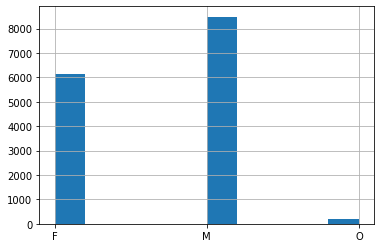

In [352]:
profile['gender'].hist()

## Lets analyze the transcript dataset



We have three different keys in the **value** column offer id, offer_id ,  amount and reward

In [550]:
def determine_offerid_value(d):
    return d['offer_id'] if (d.get('offer_id') is not None) else d.get('offer id')

### Let's add a new column to the transcript dataframe for each key that is in the Value column, we already know that they are (amount, reward, offer_id and offer id ) 

In [551]:
transcript.loc[:,'offer_id'] = transcript['value'].apply(lambda d: determine_offerid_value(d) if (type(d) is dict) else ' ')

In [552]:
transcript.loc[:,'amount'] = transcript[transcript['event']=='transaction']['value'].apply(lambda d: d['amount'])

In [553]:
transcript.loc[:,'reward'] = transcript[transcript['event']=='offer completed']['value'].apply(lambda d: d['reward'])

In [554]:
transcript[transcript['event']=='offer completed'].head(2)

,person,event,value,time,offer_id,amount,reward
12658,9fa9ae8f57894cc9a3b8a9bbe0fc1b2f,offer completed,{'offer_id': '2906b810c7d4411798c6938adc9daaa5...,0,2906b810c7d4411798c6938adc9daaa5,NaN,2.0
12672,fe97aa22dd3e48c8b143116a8403dd52,offer completed,{'offer_id': 'fafdcd668e3743c1bb461111dcafc2a4...,0,fafdcd668e3743c1bb461111dcafc2a4,NaN,2.0


In [555]:
transcript[transcript['event']=='transaction'].head(2)

,person,event,value,time,offer_id,amount,reward
12654,02c083884c7d45b39cc68e1314fec56c,transaction,{'amount': 0.8300000000000001},0,None,0.83,NaN
12657,9fa9ae8f57894cc9a3b8a9bbe0fc1b2f,transaction,{'amount': 34.56},0,None,34.56,NaN


## Lets see a set of transactions for a single client

In [568]:
single_client_transaction_log = transcript.loc[transcript['person'] == transcript.iloc[0,0]].sort_values('time')
single_client_transaction_log.head(10)

,person,event,value,time,offer_id,amount,reward
0,78afa995795e4d85b5d9ceeca43f5fef,offer received,{'offer id': '9b98b8c7a33c4b65b9aebfe6a799e6d9'},0,9b98b8c7a33c4b65b9aebfe6a799e6d9,NaN,NaN
15561,78afa995795e4d85b5d9ceeca43f5fef,offer viewed,{'offer id': '9b98b8c7a33c4b65b9aebfe6a799e6d9'},6,9b98b8c7a33c4b65b9aebfe6a799e6d9,NaN,NaN
47582,78afa995795e4d85b5d9ceeca43f5fef,transaction,{'amount': 19.89},132,None,19.89,NaN
47583,78afa995795e4d85b5d9ceeca43f5fef,offer completed,{'offer_id': '9b98b8c7a33c4b65b9aebfe6a799e6d9...,132,9b98b8c7a33c4b65b9aebfe6a799e6d9,NaN,5.0
49502,78afa995795e4d85b5d9ceeca43f5fef,transaction,{'amount': 17.78},144,None,17.78,NaN
53176,78afa995795e4d85b5d9ceeca43f5fef,offer received,{'offer id': '5a8bc65990b245e5a138643cd4eb9837'},168,5a8bc65990b245e5a138643cd4eb9837,NaN,NaN
85291,78afa995795e4d85b5d9ceeca43f5fef,offer viewed,{'offer id': '5a8bc65990b245e5a138643cd4eb9837'},216,5a8bc65990b245e5a138643cd4eb9837,NaN,NaN
87134,78afa995795e4d85b5d9ceeca43f5fef,transaction,{'amount': 19.67},222,None,19.67,NaN
92104,78afa995795e4d85b5d9ceeca43f5fef,transaction,{'amount': 29.72},240,None,29.72,NaN
141566,78afa995795e4d85b5d9ceeca43f5fef,transaction,{'amount': 23.93},378,None,23.93,NaN


In [557]:
relation_event_person = transcript.groupby(['person', 'event'])['time'].count()
relation_event_person.head(20)

person                            event          
0009655768c64bdeb2e877511632db8f  offer completed     3
                                  offer received      5
                                  offer viewed        4
                                  transaction         8
00116118485d4dfda04fdbaba9a87b5c  offer received      2
                                  offer viewed        2
                                  transaction         3
0011e0d4e6b944f998e987f904e8c1e5  offer completed     3
                                  offer received      5
                                  offer viewed        5
                                  transaction         5
0020c2b971eb4e9188eac86d93036a77  offer completed     3
                                  offer received      5
                                  offer viewed        3
                                  transaction         8
0020ccbbb6d84e358d3414a3ff76cffd  offer completed     3
                                  offer received      

In [559]:
portfolio =  portfolio.rename(columns={'id':'offer_id'})
transactions_offers   =  pd.merge( transcript , portfolio[['offer_id', 'difficulty','duration',	'offer_type']], 
                                                          on='offer_id', how='left')

In [567]:
transactions_offers.head(5)

,person,event,value,time,offer_id,amount,reward,difficulty,duration,offer_type
0,78afa995795e4d85b5d9ceeca43f5fef,offer received,{'offer id': '9b98b8c7a33c4b65b9aebfe6a799e6d9'},0,9b98b8c7a33c4b65b9aebfe6a799e6d9,NaN,NaN,5.0,7.0,bogo
1,a03223e636434f42ac4c3df47e8bac43,offer received,{'offer id': '0b1e1539f2cc45b7b9fa7c272da2e1d7'},0,0b1e1539f2cc45b7b9fa7c272da2e1d7,NaN,NaN,20.0,10.0,discount
2,e2127556f4f64592b11af22de27a7932,offer received,{'offer id': '2906b810c7d4411798c6938adc9daaa5'},0,2906b810c7d4411798c6938adc9daaa5,NaN,NaN,10.0,7.0,discount
3,8ec6ce2a7e7949b1bf142def7d0e0586,offer received,{'offer id': 'fafdcd668e3743c1bb461111dcafc2a4'},0,fafdcd668e3743c1bb461111dcafc2a4,NaN,NaN,10.0,10.0,discount
4,68617ca6246f4fbc85e91a2a49552598,offer received,{'offer id': '4d5c57ea9a6940dd891ad53e9dbe8da0'},0,4d5c57ea9a6940dd891ad53e9dbe8da0,NaN,NaN,10.0,5.0,bogo


In [263]:
offers_viewed   = transactions_offers.loc[ transactions_offers['event'] == 'offer viewed',:]

In [566]:
offers_viewed.set_index(['person','offer_id'])
offers_viewed.head(4)

,person,event,value,time,offer_id,reward,difficulty,duration,offer_type
12650,389bc3fa690240e798340f5a15918d5c,offer viewed,{'offer id': 'f19421c1d4aa40978ebb69ca19b0e20d'},0,f19421c1d4aa40978ebb69ca19b0e20d,5.0,5.0,5.0,bogo
12651,d1ede868e29245ea91818a903fec04c6,offer viewed,{'offer id': '5a8bc65990b245e5a138643cd4eb9837'},0,5a8bc65990b245e5a138643cd4eb9837,0.0,0.0,3.0,informational
12652,102e9454054946fda62242d2e176fdce,offer viewed,{'offer id': '4d5c57ea9a6940dd891ad53e9dbe8da0'},0,4d5c57ea9a6940dd891ad53e9dbe8da0,10.0,10.0,5.0,bogo
12653,02c083884c7d45b39cc68e1314fec56c,offer viewed,{'offer id': 'ae264e3637204a6fb9bb56bc8210ddfd'},0,ae264e3637204a6fb9bb56bc8210ddfd,10.0,10.0,7.0,bogo


In [266]:
offers_viewed.shape

(57725, 9)

### Let us now look at the completed offers, it is important to note that this includes all completed offers regardless of whether they were seen or not previously

In [267]:
offers_completed = transactions_offers.loc[ transactions_offers['event'] == 'offer completed',:]

In [574]:
offers_completed.set_index('person','offer_id')
offers_completed.sort_values(by=['person','time']).head(4)

,person,event,value,time,offer_id,reward,difficulty,duration,offer_type
168413,0009655768c64bdeb2e877511632db8f,offer completed,{'offer_id': 'f19421c1d4aa40978ebb69ca19b0e20d...,414,f19421c1d4aa40978ebb69ca19b0e20d,5.0,5.0,5.0,bogo
228423,0009655768c64bdeb2e877511632db8f,offer completed,{'offer_id': 'fafdcd668e3743c1bb461111dcafc2a4...,528,fafdcd668e3743c1bb461111dcafc2a4,2.0,10.0,10.0,discount
258884,0009655768c64bdeb2e877511632db8f,offer completed,{'offer_id': '2906b810c7d4411798c6938adc9daaa5...,576,2906b810c7d4411798c6938adc9daaa5,2.0,10.0,7.0,discount
95422,0011e0d4e6b944f998e987f904e8c1e5,offer completed,{'offer_id': '2298d6c36e964ae4a3e7e9706d1fb8c2...,252,2298d6c36e964ae4a3e7e9706d1fb8c2,3.0,7.0,7.0,discount


### Now, let's select only those offers that were completed after having been viewed previously

In [533]:
viewed_and_completed = pd.merge ( offers_completed , offers_viewed.loc[:,['person', 'offer_id']], on=['person','offer_id'])

In [569]:
viewed_and_completed.sort_values(by=['person'])
viewed_and_completed.head(5)

,person,event,value,time,offer_id,reward,difficulty,duration,offer_type
0,9fa9ae8f57894cc9a3b8a9bbe0fc1b2f,offer completed,{'offer_id': '2906b810c7d4411798c6938adc9daaa5...,0,2906b810c7d4411798c6938adc9daaa5,2.0,10.0,7.0,discount
1,fe97aa22dd3e48c8b143116a8403dd52,offer completed,{'offer_id': 'fafdcd668e3743c1bb461111dcafc2a4...,0,fafdcd668e3743c1bb461111dcafc2a4,2.0,10.0,10.0,discount
2,629fc02d56414d91bca360decdfa9288,offer completed,{'offer_id': '9b98b8c7a33c4b65b9aebfe6a799e6d9...,0,9b98b8c7a33c4b65b9aebfe6a799e6d9,5.0,5.0,7.0,bogo
3,676506bad68e4161b9bbaffeb039626b,offer completed,{'offer_id': 'ae264e3637204a6fb9bb56bc8210ddfd...,0,ae264e3637204a6fb9bb56bc8210ddfd,10.0,10.0,7.0,bogo
4,8f7dd3b2afe14c078eb4f6e6fe4ba97d,offer completed,{'offer_id': '4d5c57ea9a6940dd891ad53e9dbe8da0...,0,4d5c57ea9a6940dd891ad53e9dbe8da0,10.0,10.0,5.0,bogo


In [534]:
viewed_and_completed.shape

(37952, 9)

In [576]:
viewed_and_completed.drop_duplicates(['person', 'offer_id', 'time']).head(5)

,person,event,value,time,offer_id,reward,difficulty,duration,offer_type
0,9fa9ae8f57894cc9a3b8a9bbe0fc1b2f,offer completed,{'offer_id': '2906b810c7d4411798c6938adc9daaa5...,0,2906b810c7d4411798c6938adc9daaa5,2.0,10.0,7.0,discount
1,fe97aa22dd3e48c8b143116a8403dd52,offer completed,{'offer_id': 'fafdcd668e3743c1bb461111dcafc2a4...,0,fafdcd668e3743c1bb461111dcafc2a4,2.0,10.0,10.0,discount
2,629fc02d56414d91bca360decdfa9288,offer completed,{'offer_id': '9b98b8c7a33c4b65b9aebfe6a799e6d9...,0,9b98b8c7a33c4b65b9aebfe6a799e6d9,5.0,5.0,7.0,bogo
3,676506bad68e4161b9bbaffeb039626b,offer completed,{'offer_id': 'ae264e3637204a6fb9bb56bc8210ddfd...,0,ae264e3637204a6fb9bb56bc8210ddfd,10.0,10.0,7.0,bogo
4,8f7dd3b2afe14c078eb4f6e6fe4ba97d,offer completed,{'offer_id': '4d5c57ea9a6940dd891ad53e9dbe8da0...,0,4d5c57ea9a6940dd891ad53e9dbe8da0,10.0,10.0,5.0,bogo


### Let us now select the people who completed an offer after seeing it


In [276]:
poi_s = df_responded['person'].unique()
persons_of_interest = pd.DataFrame({'id':poi_s})

In [277]:
persons_of_interest.head()

,id
0,9fa9ae8f57894cc9a3b8a9bbe0fc1b2f
1,fe97aa22dd3e48c8b143116a8403dd52
2,629fc02d56414d91bca360decdfa9288
3,676506bad68e4161b9bbaffeb039626b
4,8f7dd3b2afe14c078eb4f6e6fe4ba97d


In [278]:
persons_of_interest.shape

(12202, 1)

In [279]:
profile.head()

,gender,age,id,became_member_on,income
0,None,118,68be06ca386d4c31939f3a4f0e3dd783,20170212,NaN
1,F,55,0610b486422d4921ae7d2bf64640c50b,20170715,112000.0
2,None,118,38fe809add3b4fcf9315a9694bb96ff5,20180712,NaN
3,F,75,78afa995795e4d85b5d9ceeca43f5fef,20170509,100000.0
4,None,118,a03223e636434f42ac4c3df47e8bac43,20170804,NaN


In [80]:
profile.shape

(17000, 5)

In [280]:
profiles_of_interest = pd.merge (persons_of_interest,profile,on='id')

In [281]:
profiles_of_interest.sort_values(by=['id'])
profiles_of_interest.head(10)

,id,gender,age,became_member_on,income
0,9fa9ae8f57894cc9a3b8a9bbe0fc1b2f,M,42,20160117,96000.0
1,fe97aa22dd3e48c8b143116a8403dd52,F,39,20171217,67000.0
2,629fc02d56414d91bca360decdfa9288,M,52,20180605,72000.0
3,676506bad68e4161b9bbaffeb039626b,M,37,20170515,92000.0
4,8f7dd3b2afe14c078eb4f6e6fe4ba97d,M,48,20150903,62000.0
5,227f2d69e46a4899b70d48182822cff6,M,51,20180512,100000.0
6,bb0f25e23a4c4de6a645527c275cd594,M,56,20140611,76000.0
7,d72d201be5794279aa716d8ad82b8d90,F,51,20160223,73000.0
8,73ffefd41e9a4ca3ab26b2b3697c6eb7,F,67,20150929,67000.0
9,3e621194f72e40d7a0b695ee9b7c38b7,F,59,20170816,90000.0


In [282]:
profiles_of_interest.shape

(12202, 5)

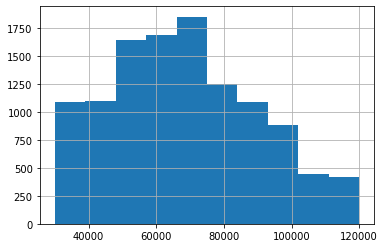

In [283]:
profiles_of_interest['income'].hist()